# Moving Average Crossover Strategy

The strategy is as follows:

1. Calculate the 5 day simple moving average 'mean' 
2. Calculate the 30 day simple moving average 'mean_Long'
3. Calculating the SMA_diff = 'mean' - 'mean_Long' 

The day when SMA_diff goes from negative to positive gives me the BUY signal and SMA_diff going from positive to negative gives me the SELL signal. Here I am only taking the long position. Each trade uses the adjusted closing price of the day after the day for which I get the BUY/SELL signal. This is because the signals are generated using the closing price of the day at the end of the day and thus taking the same price for the trade will introduce a look ahead bias.

I am taking Reliance Industries stock prices (NSE) for testing the strategy. I have 5 year data with opening ,closing and adjusted close prices. 

I will also be comparing the strategy returns with a simple buy and hold strategy,  ie buying the stock at the start of the 5 year test period and holding it throughout.


Populating the interactive namespace from numpy and matplotlib


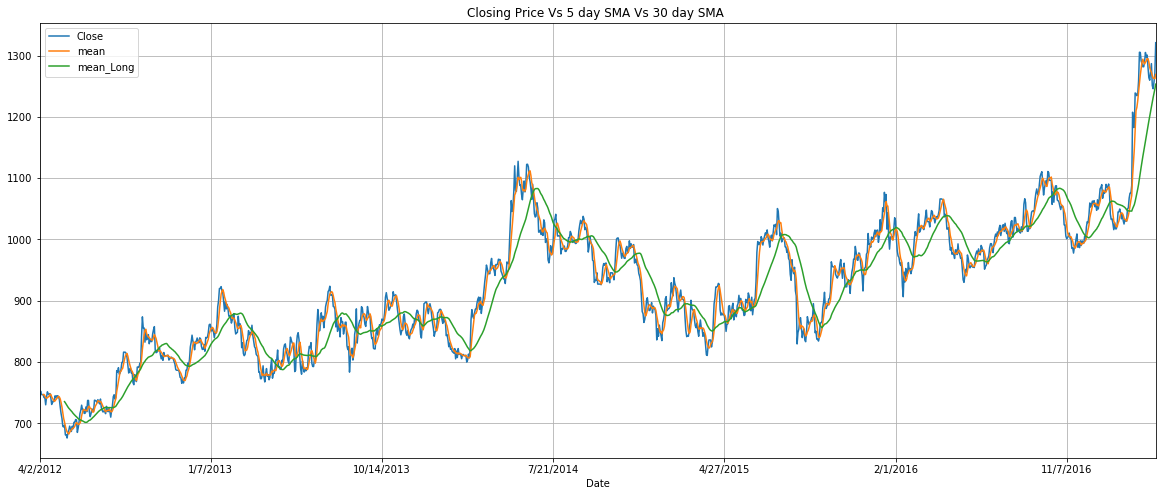

In [316]:
%pylab inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.options.mode.chained_assignment = None

def getData():
    df = pd.read_csv('table.csv')
    return df

df = getData()

#defing the small and long lookbacks
small_lookback = 5 
long_lookback = 30

df['mean'] = df['Close'].rolling(window = small_lookback ,min_periods = small_lookback).mean()
df['mean_Long'] = df['Close'].rolling(window = long_lookback ,min_periods = long_lookback).mean()

df.plot(x='Date',y=['Close','mean','mean_Long'],figsize=(20,8),grid=True,title = "Closing Price Vs 5 day SMA Vs 30 day SMA ")


The above graphs shows the closing prices of the stock in blue , 5day moving average in orange and 30 day moving average in green. As defined by the strategy above, it can be seen that our BUY and SELL signals using the crossovers capture the actual price movement well enough. 

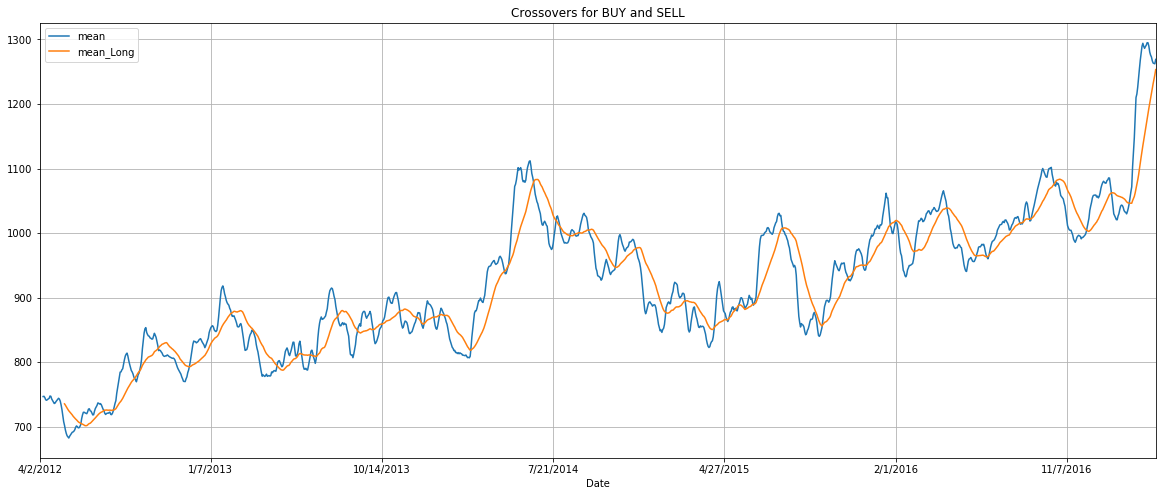

In [318]:
# Plotting the crossover points here
df.plot(x='Date',y=['mean','mean_Long'],figsize=(20, 8),grid = True ,title = "Crossovers for BUY and SELL")

#the difference curve which will give me the indicators for BUY and SELL signal
df['SMA_diff'] = df['mean'] - df['mean_Long']
df['zero_line'] = 0

df['Signal'] = 0

# creating the signals
for index, row in df.iterrows(): 
    if index != 0 :
        if df['SMA_diff'][index-1]<0 and df['SMA_diff'][index] >=0: 
            df['Signal'][index] =  "BUY"    
#             print df['Date'][index],"BUY"
        elif df['SMA_diff'][index-1]>0 and df['SMA_diff'][index] <=0:
            df['Signal'][index] = "SELL"
#             print df['Date'][index],"SELL"


In the coming section of the code , I have created the returns on hypothetical portfolio with zero initial cash and buying and selling 100 shares everytime I get the indicator. The trades are made using the adjusted

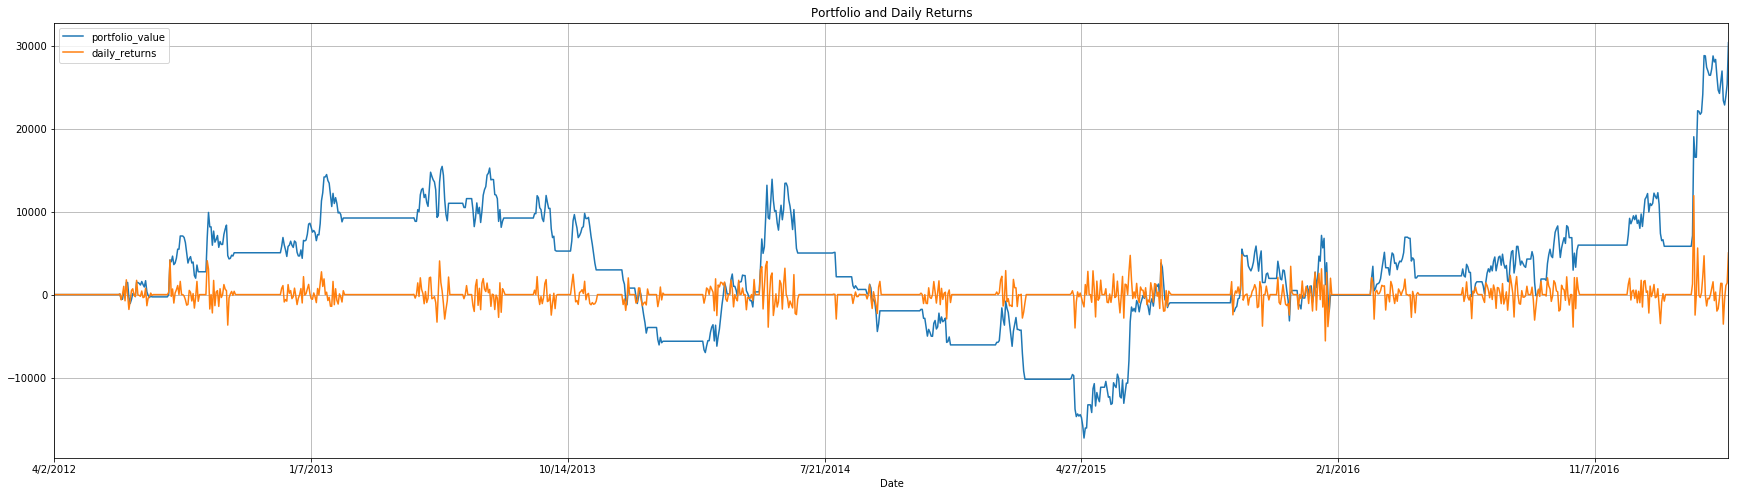

In [319]:
df['portfolio_value'] = 0
df['daily_returns'] = 0 

#df['current_position'] will capture our position in the market which is either long or neutral 
df['current_position'] = 0
cash = 0
holding = 0
pos = 0

for i,row in df.iterrows():
    if i != 0 :
        #checking if the previous day's signal was buy or sell. 
        if df['Signal'][i-1] != 0:
    
            if df['Signal'][i-1] == 'BUY':
                cash -= df['Adj Close'][i]*100
                holding += 100
                pos = 1
            elif df['Signal'][i-1] == 'SELL':
                cash += df['Adj Close'][i]*100
                holding -= 100
                pos = 0
    
    df['portfolio_value'][i] = cash + holding*df['Adj Close'][i]

    if i != 0:
        df['daily_returns'][i] = df['portfolio_value'][i] - df['portfolio_value'][i-1]
        
    df['current_position'][i] = 1 if pos == 1 else 0
    
df.plot(x='Date',y=['portfolio_value','daily_returns'],figsize=(30, 8),grid = True,title = 'Portfolio and Daily Returns')


Here I have plotted the returns on the portfolio as well the daily returns I am getting on the portfolio. The portfolio starts with 0 intial cash . Thus the final number in the end gives the absolute return on the portfolio. 

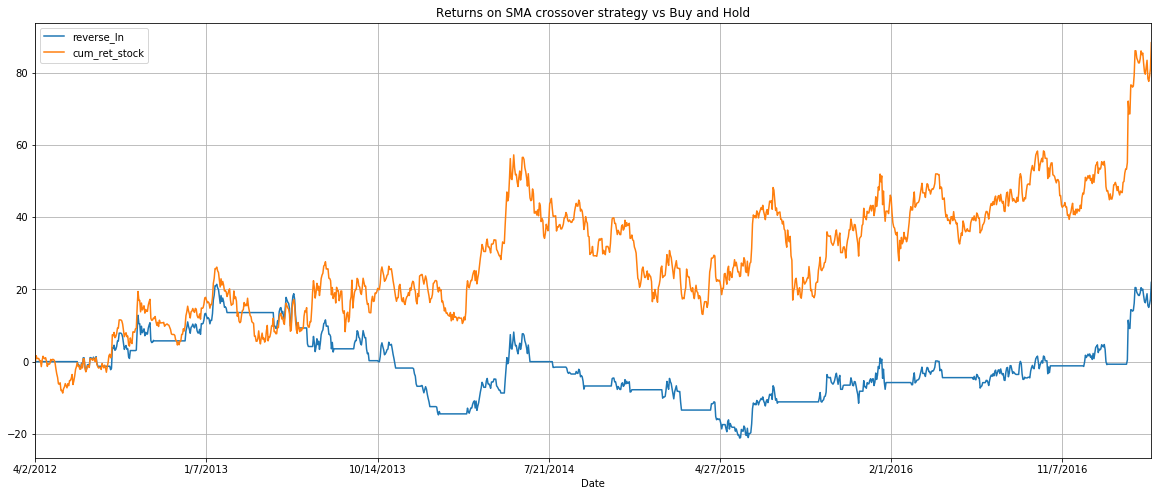

In [322]:
# capturing the daily change in the values
df['daily_change'] = ((df['Adj Close']/ df['Adj Close'].shift(1)) - 1)       
# taking logs for addition of returns
df['ln_daily_change'] = np.log(df['Adj Close']/ df['Adj Close'].shift(1))

# ln returns on the  strategy using our position of long/neutral in the market
df['strategy_daily_return_percent'] = df['ln_daily_change']*df['current_position']

# cumalative_daily_returns will capture our cumalative returns on the strategy
df['cumalative_daily_returns'] = 0.0

# exposenential of cumalative_daily_returns 
df['reverse_ln'] = 0.0

# cum_ret_stock captures the return on simple buy and hold strategy .
df['cum_ret_stock'] = 0.0

for i,row in df.iterrows():
    
    if i!=0 : 
        df['cumalative_daily_returns'][i] = df['strategy_daily_return_percent'][i] + df['cumalative_daily_returns'][i-1]
        df['reverse_ln'][i] = (np.exp(df['cumalative_daily_returns'][i])-1)*100
        df['cum_ret_stock'][i] = (1+df['cum_ret_stock'][i-1])*(1+df['daily_change'][i]) - 1

df['cum_ret_stock'] = df['cum_ret_stock']*100

df.plot(x='Date',y=['reverse_ln','cum_ret_stock'],figsize=(20, 8),grid =True , title = 'Returns on SMA crossover strategy vs Buy and Hold')
    

The blue curve shows the return on our moving average crossover strategy whereas the orange one show the return on simple buy and hold till the end strategy 